# 日経平均株価 15分足

### 一つ上のディレクトリをパスに追加

In [36]:
import sys
path_up = '..'
if not path_up in sys.path:
    sys.path.append(path_up)

### ライブラリをここで一括インポート

In [37]:
import datetime

import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import mplfinance as mpf
import numpy as np
import pandas as pd
import yfinance as yf

from funcs.common import get_name_15min_chart, get_name_15min_chart_now

## yfinance による株価データの取得

In [38]:
code = "N225"
symbol = f"^{code}"
ticker = yf.Ticker(symbol)
df = ticker.history(period='1d', interval='15m')
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2025-06-12 09:00:00+09:00,38324.929688,38407.570312,38293.871094,38338.148438,0,0.0,0.0
2025-06-12 09:15:00+09:00,38340.968750,38342.171875,38181.601562,38190.531250,0,0.0,0.0
2025-06-12 09:30:00+09:00,38192.699219,38237.898438,38121.640625,38168.250000,0,0.0,0.0
2025-06-12 09:45:00+09:00,38167.671875,38172.148438,38107.320312,38165.468750,0,0.0,0.0
2025-06-12 10:00:00+09:00,38168.308594,38217.449219,38160.960938,38177.859375,0,0.0,0.0
2025-06-12 10:15:00+09:00,38175.441406,38191.789062,38121.488281,38134.378906,0,0.0,0.0
2025-06-12 10:30:00+09:00,38135.109375,38149.671875,38102.050781,38137.218750,0,0.0,0.0
2025-06-12 10:45:00+09:00,38137.968750,38166.761719,38104.769531,38155.050781,0,0.0,0.0
2025-06-12 11:00:00+09:00,38156.039062,38175.718750,38128.878906,38150.628906,0,0.0,0.0


## 前日終値の取得

In [39]:
# 過去一週間のデータを取得
td = datetime.timedelta(days=7)
dt_first = df.index[0]
dt_prev = dt_first - td
df_last = ticker.history(period='1d', interval='1d', start=str(dt_prev.date()))
n = len(df_last)
lastclose = df_last[n-2:n-1]['Close'].iloc[0]
# 確認のため出力
df_last[n-2:n-1]['Close']

Date
2025-06-11 00:00:00+09:00    38421.191406
Name: Close, dtype: float64

## ローソク足チャート（小さいサイズ）

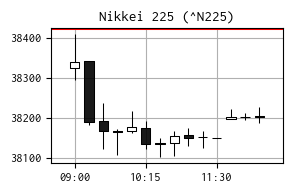

In [40]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams['font.family'] = font_prop.get_name()
plt.rcParams['font.size'] = 9

fig, ax = plt.subplots(figsize=(3, 2))
mpf.plot(
    df,
    type='candle',
    style='default',
    datetime_format='%H:%M',
    xrotation=0,
    update_width_config=dict(candle_linewidth=0.75),
    ax=ax,
)
ax.axhline(y=lastclose, color="red", linewidth=0.75)
ax.set_ylabel(None)
ax.grid()

if "shortName" in ticker.info:
    ax.set_title(f"{ticker.info['shortName']} ({symbol})")
elif "longName" in ticker.info:
    ax.set_title(f"{ticker.info['longName']} ({symbol})")
else:
    ax.set_title(f"{symbol}")
    
plt.tight_layout()
plt.savefig(get_name_15min_chart(code, dt_first))
plt.show()